# Y2H quality control checks

Here we're looking for any potential problems with any of the ~500 Y2H large plates. There are 3 replicates for each plate. We look for problems by plotting different metrics and comparing between all the plates using the same media and within the replicates. 

**NOTE: we previously found swapped and mislabelled plates. Those have now been corrected in the database (22nd Nov 2019). The comments below refer to those findings and now don't match the plots/data.**

In [1]:
import os
import re

from matplotlib import pyplot as plt
import pandas as pd

import ccsblib

In [2]:
fig_dir = '../../figures/QC'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
qry = """select *
            from tf_screen.tf_isoform_final
            left join tf_screen.retest
            using (retest_id);"""
df = pd.read_sql(qry, ccsblib.paros_connection())
df = df.loc[:, ['standard_batch', 'retest_pla', 'retest_pos', 'seq_confirmation'] +
               [c for c in df.columns if c.endswith('_score') and '_repeat_' in c]]
df = df.drop_duplicates()
df = df.melt(id_vars=['standard_batch', 'retest_pla', 'retest_pos', 'seq_confirmation'],
             value_vars=[c for c in df.columns if c.endswith('_score')],
             var_name='media_rep',
             value_name='score')

In [4]:
df['media'] = df['media_rep'].apply(lambda x: {'lw': 'LW', 'chx': 'CX', '3at': 'AT'}[x.split('_')[0]])
df['rep'] = df['media_rep'].apply(lambda x: 'ABC'[int(x.split('_')[2]) - 1])
df.head()

,standard_batch,retest_pla,retest_pos,seq_confirmation,media_rep,score,media,rep
0,TFr11,1,F01,y,3at_repeat_1_score,0.0,AT,A
1,TFr11,1,E02,y,3at_repeat_1_score,0.0,AT,A
2,TFr11,1,D02,y,3at_repeat_1_score,0.0,AT,A
3,TFr11,1,C02,None,3at_repeat_1_score,0.0,AT,A
4,TFr11,1,B02,y,3at_repeat_1_score,2.5,AT,A


In [5]:
base_dir = '/Volumes/mvidal/projects/TF_Iso_Var/Y2H_TF_Iso/191106_grab_all_tfiso_colony_images/a_all_colony_images'
all_img_files = os.listdir(base_dir)

def big_plate_image(row):
    file_regexp = ('{std_batch}.{media}.rep{rep}(_([0-9]{{3}}|xxx|xx|XXX)){{6}}.JPG'
                       .format(std_batch=row['standard_batch'],
                               media=row['media'],
                               rep=row['rep']))
    matching_files = [s for s in all_img_files
                        if re.match(file_regexp, s)
                        and str(row['retest_pla']).zfill(3) in s]
    if len(matching_files) == 0:
        raise UserWarning('could not find file')
    if len(matching_files) > 1:
        raise UserWarning('found multiple files')
    return matching_files[0]

df_b = df.loc[:, ['standard_batch', 'retest_pla', 'media', 'rep']].drop_duplicates().copy()
df_b['big_plate'] = df_b.apply(big_plate_image, axis=1)
df = pd.merge(df, df_b, on=['standard_batch', 'retest_pla', 'media', 'rep'], how='left')

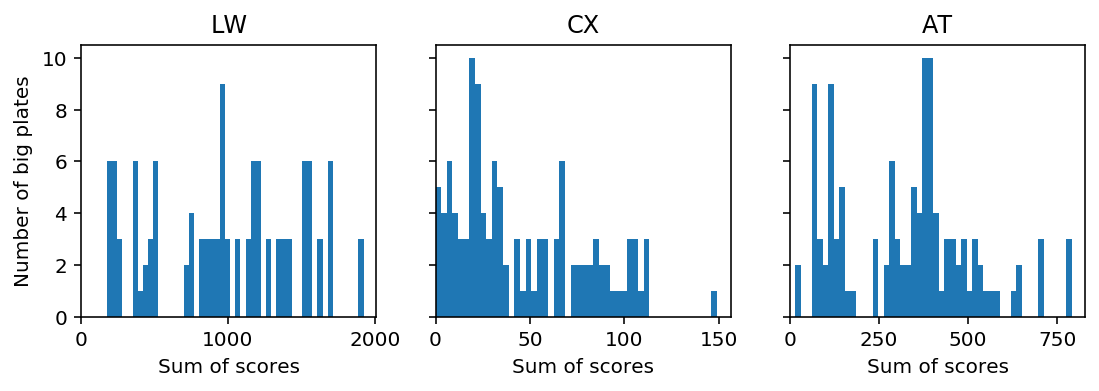

In [6]:
# negative scores are NA
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media) & 
                   (df['score'] >= 0) , :]
              .groupby('big_plate')['score'].sum(),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('Sum of scores')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'sum_of_scores.pdf'),
            bbox_inches='tight')

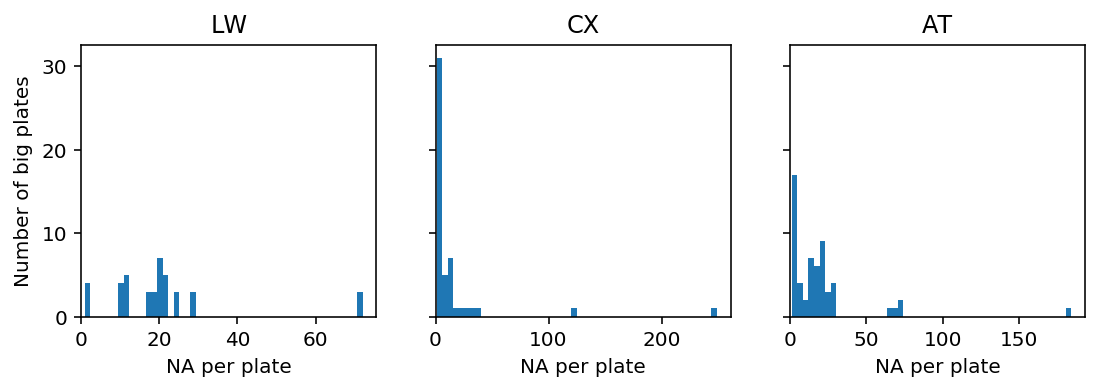

In [7]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media) & 
                   (df['score'] < 0) , :]
              .groupby('big_plate').size(),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('NA per plate')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'NA_per_big_plate.pdf'),
            bbox_inches='tight')

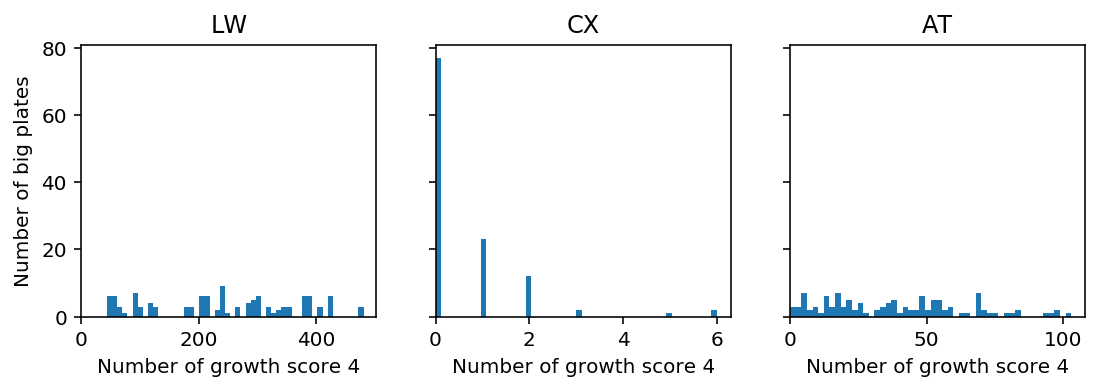

In [8]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media), :]
              .groupby('big_plate')['score'].apply(lambda x: (x == 4).sum()),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('Number of growth score 4')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'growth_score_4_per_big_plate.pdf'),
            bbox_inches='tight')

In [9]:
# CHX with the most growth score 4
(df.loc[(df['media'] == 'CX'), :]
   .groupby('big_plate')['score']
   .apply(lambda x: (x == 4).sum())
   .sort_values(ascending=False).head())

big_plate
TFr09.CX.repC_025_026_027_028_029_030.JPG    6
TFr09.CX.repB_025_026_027_028_029_030.JPG    6
TFr09.CX.repB_019_020_021_022_023_024.JPG    5
TFr09.CX.repB_031_032_033_034_035_036.JPG    3
TFr09.CX.repA_025_026_027_028_029_030.JPG    3
Name: score, dtype: int64

In [10]:
# CHX with most overall growth
(df.loc[df['media'] == 'CX', :]
     .groupby('big_plate')['score'].sum()
    .sort_values(ascending=False).head())

big_plate
TFr09.CX.repB_019_020_021_022_023_024.JPG    149.0
TFr09.CX.repA_001_002_003_004_005_006.JPG    113.0
TFr09.CX.repA_007_008_009_010_011_012.JPG    110.0
TFr09.CX.repA_019_020_021_022_023_024.JPG    109.5
TFr09.CX.repB_037_038_039_040_041_042.JPG    109.0
Name: score, dtype: float64

In [11]:
# CHX with most nulls
(df.loc[(df['media'] == 'CX') &
        (df['score'] < 0), :]
     .groupby('big_plate')
     .size()
     .sort_values(ascending=False).head())

big_plate
TFr07.CX.repB_055_056_057_058_059_060.JPG    249
TFr07.CX.repA_031_032_033_034_035_036.JPG    122
TFr11.CX.repB_007_008_009_010_011_012.JPG     38
TFr11.CX.repB_001_002_003_004_005_006.JPG     32
TFr11.CX.repA_019_020_021_022_023_024.JPG     27
dtype: int64

In [12]:
(df.loc[(df['media'] == 'AT') &
        (df['score'] < 0), :]
    .groupby('big_plate')
    .size()
    .sort_values(ascending=False).head())

big_plate
TFr07.AT.repB_097_098_099_100_101_102.JPG    184
TFr12.AT.repC_019_020_021_022_023_024.JPG     73
TFr12.AT.repA_019_020_021_022_023_024.JPG     72
TFr12.AT.repB_019_020_021_022_023_024.JPG     68
TFr12.AT.repB_025_028_029_030_xxx_xxx.JPG     64
dtype: int64

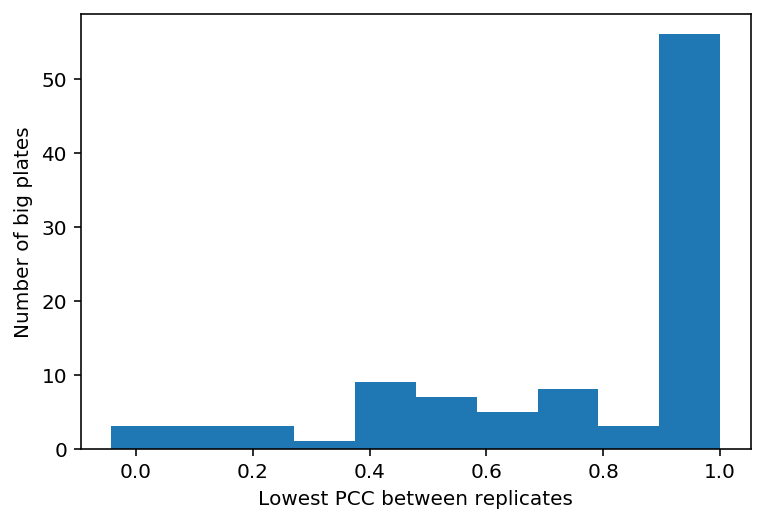

In [13]:
# correlations between replicates
df['big_plate_grouping'] = df['big_plate'].str.replace('rep[ABC]', '')
df['plate_pos'] = df['retest_pla'].astype(str) + '_' + df['retest_pos']

def min_corr_reps(rows):
    return rows.pivot(index='plate_pos', columns='rep', values='score').corr().min().min()


def idx_min_corr_reps(rows):
    return rows.pivot(index='plate_pos', columns='rep', values='score').corr().stack().idxmin()


def mean_abs_diff_reps(rows):
    d = rows.pivot(index='plate_pos', columns='rep', values='score')
    if 'A' in d.columns and 'B' in d.columns:
        d_ab = (d['A'] - d['B']).abs().sum() / (d['A'].notnull() & d['B'].notnull()).sum()
    else:
        d_ab = 0
    if 'A' in d.columns and 'C' in d.columns:
        d_ac = (d['A'] - d['C']).abs().sum() / (d['A'].notnull() & d['C'].notnull()).sum()
    else:
        d_ac = 0
    if 'B' in d.columns and 'C' in d.columns:
        d_bc = (d['B'] - d['C']).abs().sum() / (d['B'].notnull() & d['C'].notnull()).sum()
    else:
        d_bc = 0
    return max([d_ab, d_ac, d_bc])

reps = df.groupby('big_plate_grouping').apply(min_corr_reps).rename('min_pcc').to_frame()
reps = reps.loc[(df.groupby('big_plate_grouping')['rep'].nunique() > 1), :]
reps = reps.dropna()
reps['min_pair'] = df.loc[df['big_plate_grouping'].isin(reps.index), :].groupby('big_plate_grouping').apply(idx_min_corr_reps)
reps['mean_abs_diff'] = df.loc[df['big_plate_grouping'].isin(reps.index), :].groupby('big_plate_grouping').apply(mean_abs_diff_reps)

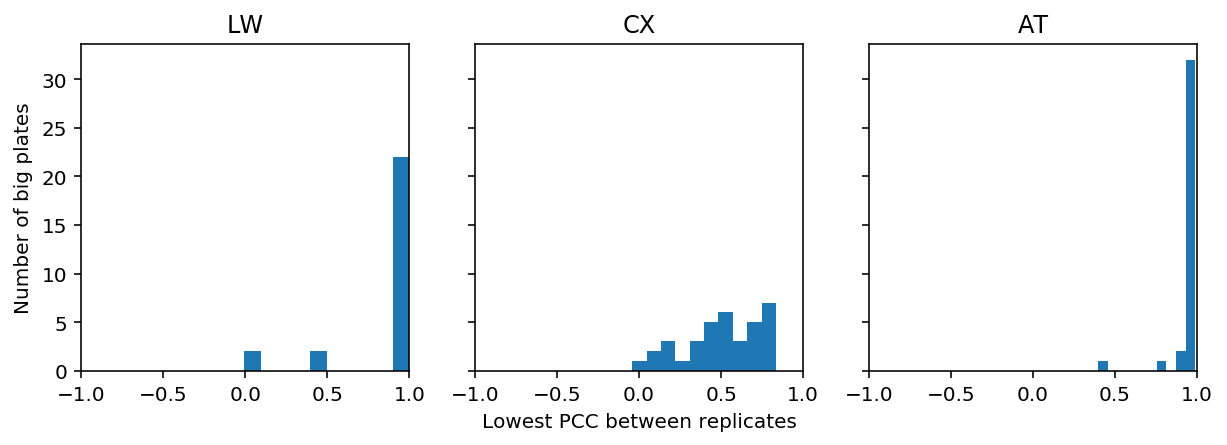

In [14]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(10, 3)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(reps.loc[reps.index.map(lambda x: media in x), 'min_pcc'])
    ax.set_xlim(-1, 1)
axes[1].set_xlabel('Lowest PCC between replicates');
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'replicate_pcc.pdf'),
            bbox_inches='tight')

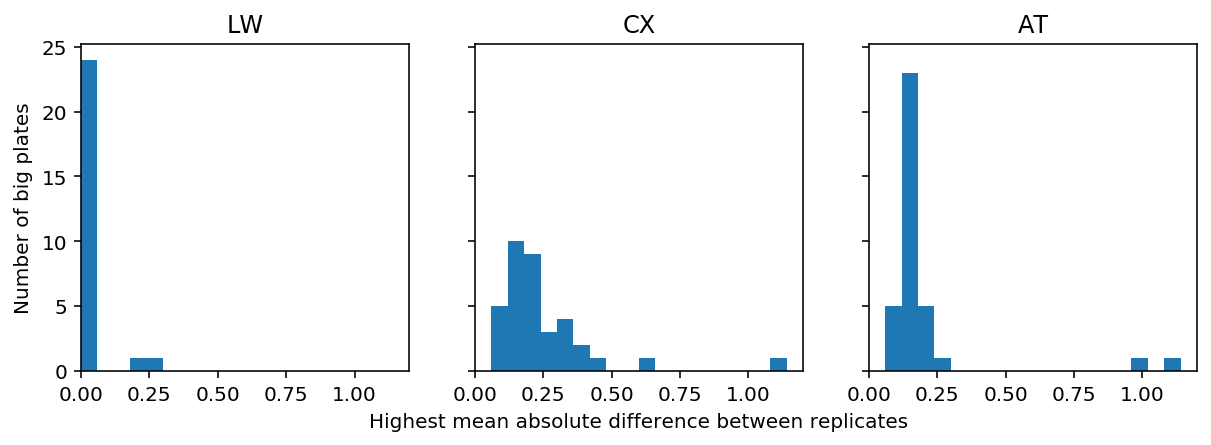

In [15]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(10, 3)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(reps.loc[reps.index.map(lambda x: media in x), 'mean_abs_diff'],
            bins=20,
            range=(0., 1.2))
    ax.set_xlim(0, 1.2)
axes[1].set_xlabel('Highest mean absolute difference between replicates');
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'replicate_mean_abs_diff.pdf'),
            bbox_inches='tight')

## Some notes after following up by looking at the plate images

### PCC between replicates

3 low values for 3AT:
- `TFr09.AT._031_032_033_034_035_036.JPG` `A/B`
    - This is the swapped 3AT/CHX plates that we previously identified.
- `TFr12.AT._025_028_029_030_xxx_xxx.JPG` `A/B`
    - plate 25 is missing from `TFr12.AT.repB_025_028_029_030_xxx_xxx.JPG`
- `TFr07.AT._097_098_099_100_101_102.JPG` `B/C`
    - Only one spot is growing on: `TFr07.AT.repB_097_098_099_100_101_102.JPG`. It appears that it is CHX, since it has identical growth to the CHX plate. It is not a swap or a duplicate image though. 

4 low values for -LW:
- `TFr07.LW._019_020_021_022_023_024.JPG` `A/B`
- `TFr07.LW._067_068_069_070_071_072.JPG` `B/C`
- `TFr07.LW._013_014_015_016_017_018.JPG` `A/B`
- `TFr09.LW._013_014_015_016_017_018.JPG` `A/B`
    - The pictures of all four pairs of plates look virtually identical.
    - The values are also close to identical
    - This is an artifact of using PCC when there is very little variance of the values
    
    
    
### Mean absolute difference between replicates

Highest value for -LW:
- `TFr12.LW._031_032_033_034_xxx_xxx.JPG`
    Looks fine. Just some shifting from 4 -> 3
    
    
Highest values for CHX:
- `TFr07.CX._031_032_033_034_035_036.JPG`
    - This is a 3AT plate. Has the same pattern of growth but does not appear to be a swap with other images.
- `TFr09.CX._031_032_033_034_035_036.JPG`
    - This is the swap we already identified
- `TFr07.CX._055_056_057_058_059_060.JPG`
    - Looks OK. Couple of strong growing wells in rep A and not in B/C 
- `TFr11.CX._007_008_009_010_011_012.JPG`
    - Some spotting trouble for replicate B


In [16]:
reps.sort_values('min_pcc').head(30)

,min_pcc,min_pair,mean_abs_diff
big_plate_grouping,,,
TFr07.CX._079_080_081_082_083_084.JPG,-0.041698,"(A, B)",0.229508
TFr07.LW._019_020_021_022_023_024.JPG,-0.005135,"(A, B)",0.010204
TFr07.LW._067_068_069_070_071_072.JPG,-0.003436,"(B, C)",0.011986
TFr07.CX._037_038_039_040_041_042.JPG,0.100631,"(B, C)",0.265625
TFr11.CX._007_008_009_010_011_012.JPG,0.120300,"(A, B)",0.444444
TFr11.CX._001_002_003_004_005_006.JPG,0.134618,"(B, C)",0.312044
TFr07.CX._049_050_051_052_053_054.JPG,0.173436,"(A, B)",0.243446
TFr07.CX._031_032_033_034_035_036.JPG,0.175477,"(B, C)",1.106557
TFr07.CX._067_068_069_070_071_072.JPG,0.228198,"(A, B)",0.147260


In [17]:
reps.sort_values('mean_abs_diff', ascending=False).head(30)

,min_pcc,min_pair,mean_abs_diff
big_plate_grouping,,,
TFr07.AT._097_098_099_100_101_102.JPG,0.788864,"(A, C)",1.138587
TFr07.CX._031_032_033_034_035_036.JPG,0.175477,"(B, C)",1.106557
TFr12.AT._025_028_029_030_xxx_xxx.JPG,0.398003,"(A, B)",0.980769
TFr07.CX._055_056_057_058_059_060.JPG,0.681246,"(B, C)",0.602389
TFr11.CX._007_008_009_010_011_012.JPG,0.120300,"(A, B)",0.444444
TFr11.CX._013_014_015_016_017_018.JPG,0.378363,"(A, B)",0.383540
TFr07.CX._061_062_063_064_065_066.JPG,0.426871,"(A, B)",0.363636
TFr11.CX._019_020_021_022_023_024.JPG,0.427155,"(A, B)",0.348214
TFr11.CX._001_002_003_004_005_006.JPG,0.134618,"(B, C)",0.312044


In [23]:
# check that this 3AT plate that is actually CHX has been set to null
(df.loc[(df['big_plate_grouping'] == 'TFr07.AT._097_098_099_100_101_102.JPG') &
       (df['rep'] == 'B'), 'score'] == -1).all()

True

In [25]:
# check that CHX plate that is actually 3AT has been set to null
(df.loc[(df['big_plate_grouping'] == 'TFr07.CX._031_032_033_034_035_036.JPG') &
       (df['rep'] == 'A'), 'score'] == -1).all()

True